In [67]:
import json
import pickle
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from collections import defaultdict

In [68]:
# result_file_path = "../result/FT_file_result/04-18_08-37_zero_prompt/final_results_Phi4_FT_3ep_file.json"
# result_file_path = "../result/FT_file_result/04-18_08-37_cot_prompt/final_results_Phi4_FT_3ep_file.json"
result_file_path = "../result/FT_file_result/04-18_08-37_fs_prompt/final_results_Phi4_FT_3ep_file.json"

# Load the JSON file
with open(result_file_path, 'r') as file:
    results = json.load(file)

print(len(results))

494


# Result Analysis

In [69]:
from random import randint 
print(json.dumps(results[randint(0, len(results))], indent=4))

{
    "index": 191,
    "file_change_id": "158810348129327",
    "lang": "PHP",
    "vuln_type": "CWE-89",
    "result": {
        "reasoning": "The code snippet provided is part of a PHP application that handles image editing and file management. The primary concern here revolves around the handling of user input, particularly in the context of file operations and directory access.",
        "cwe_id": "CWE-434"
    },
    "model": "hf.co/Kei5uke/Phi4_trained_with_file:latest",
    "version": 1,
    "error": false,
    "time": 7.633427286986262
}


In [70]:
chosen_cwes = ['79', '89', '434', '352']
langs = ['ALL', 'PHP', 'JavaScript', 'Java', 'TypeScript', 'Ruby', 'Python']

def judge_cwe(cwe):
    for chosen_cwe in chosen_cwes:
        if chosen_cwe in cwe:
            return 'CWE-'+ chosen_cwe
    return 'None'

true_label = []
pred_label = []
for result in results:
      true = result['vuln_type']

      if true == 'non_vuln': true = 'None'

      if(result['result'].get('cwe_id') != None):
        pred = judge_cwe(result['result']['cwe_id'])
        true_label.append(true)
        pred_label.append(pred)
print(len(true_label), len(pred_label))

486 486


In [71]:
print(np.unique(true_label, return_counts=True))
print(np.unique(pred_label, return_counts=True))

(array(['CWE-352', 'CWE-434', 'CWE-79', 'CWE-89', 'None'], dtype='<U7'), array([ 29,  12, 123,  79, 243]))
(array(['CWE-352', 'CWE-434', 'CWE-79', 'CWE-89', 'None'], dtype='<U7'), array([ 21,  11, 147,  89, 218]))


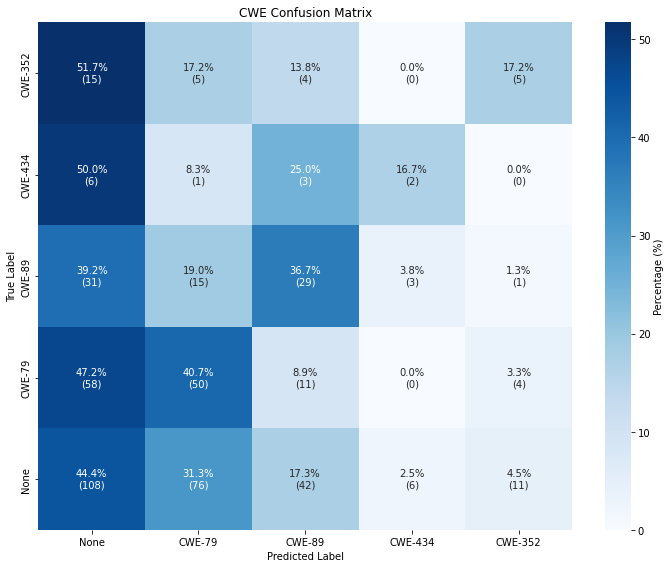

In [72]:
import numpy as np
from sklearn.metrics import confusion_matrix

cwe_classes = ['None', 'CWE-79', 'CWE-89', 'CWE-434', 'CWE-352']
language_classes = ['PHP', 'JavaScript', 'Java', 'TypeScript', 'Ruby', 'Python']

# Compute confusion matrix and normalize
cwe_cm = confusion_matrix(true_label, pred_label, labels=cwe_classes)
row_sums = cwe_cm.sum(axis=1, keepdims=True)
cwe_cm_percent = np.divide(cwe_cm, row_sums, where=row_sums!=0) * 100

# Flip the matrix and labels for desired axis orientation
cwe_cm_flipped = cwe_cm[::-1]
cwe_cm_percent_flipped = cwe_cm_percent[::-1]
flipped_labels = cwe_classes[::-1]

# Create annotations with both percentage and raw count
annot = np.empty_like(cwe_cm_percent_flipped, dtype=object)
for i in range(cwe_cm_flipped.shape[0]):
    for j in range(cwe_cm_flipped.shape[1]):
        percent = f"{cwe_cm_percent_flipped[i, j]:.1f}%"
        count = f"({cwe_cm_flipped[i, j]})"
        annot[i, j] = f"{percent}\n{count}"

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cwe_cm_percent_flipped,
    annot=annot,
    fmt="",
    cmap="Blues",
    xticklabels=cwe_classes,
    yticklabels=flipped_labels,
    cbar_kws={'label': 'Percentage (%)'}
)
plt.title("CWE Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

In [73]:
# Calculate metrics for each CWE class
cwe_table = []
for i, cwe in enumerate(cwe_classes):
    TP = cwe_cm[i, i]
    FN = cwe_cm[i, :].sum() - TP
    FP = cwe_cm[:, i].sum() - TP
    TN = cwe_cm.sum() - (TP + FP + FN)
    
    # Total actual positives (TP + FN)
    total_actual_positives = TP + FN
    # Total predicted positives (TP + FP)
    total_predicted_positives = TP + FP
    
    # Calculate ratios
    FNR = FN / (FN + TP)  # False Negative Rate (FNR)
    FPR = FP / (FP + TN)  # False Positive Rate (FPR)
    
    Acc = (TP + TN) / cwe_cm.sum()
    Precision = TP / total_predicted_positives if total_predicted_positives != 0 else 0
    Recall = TP / total_actual_positives if total_actual_positives != 0 else 0
    F1 = 2 * (Precision * Recall) / (Precision + Recall) if (Precision + Recall) != 0 else 0
    
    cwe_table.append([cwe, FN, FP, FNR, FPR, Acc, Precision, Recall, F1])

# Print CWE metrics table
print("\nCWE-Class Metrics:")
print(f"{'CWE-Class':<12} {'FNR%':<6} {'FPR%':<6} {'Acc':<6} {'Precision':<9} {'Recall':<6} {'F1':<6}") 
for row in cwe_table:
    print(f"{row[0]:<12} {row[3]:<6.2f} {row[4]:<6.2f} {row[5]:<6.2f} {row[6]:<9.2f} {row[7]:<6.2f} {row[8]:<6.2f}")


CWE-Class Metrics:
CWE-Class    FNR%   FPR%   Acc    Precision Recall F1    
None         0.56   0.45   0.50   0.50      0.44   0.47  
CWE-79       0.59   0.27   0.65   0.34      0.41   0.37  
CWE-89       0.63   0.15   0.77   0.33      0.37   0.35  
CWE-434      0.83   0.02   0.96   0.18      0.17   0.17  
CWE-352      0.83   0.04   0.92   0.24      0.17   0.20  


In [74]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


def calculate_weighted_metrics(true_label, pred_label):
    """
    Calculate weighted classification metrics (Accuracy, Recall, Precision, F1).
    
    Args:
        true_label (array-like): Ground truth labels.
        pred_label (array-like): Predicted labels.
        
    Returns:
        dict: Weighted metrics (Accuracy, Recall, Precision, F1).
    """
    # Weighted metrics (adjusts for class imbalance by weighting classes by their support)
    acc = accuracy_score(true_label, pred_label)
    recall = recall_score(true_label, pred_label, average='weighted')  # Weighted Recall (Sensitivity)
    precision = precision_score(true_label, pred_label, average='weighted')  # Weighted Precision
    f1 = f1_score(true_label, pred_label, average='weighted')  # Weighted F1-score

    # Calculate global FNR and FPR
    sum_TP = cwe_cm.diagonal().sum()
    total_samples = cwe_cm.sum()
    sum_FN = total_samples - sum_TP
    global_FNR = sum_FN / total_samples

    number_of_classes = len(cwe_classes)
    if number_of_classes > 1:
        global_FPR = sum_FN / ((number_of_classes - 1) * total_samples)
    else:
        global_FPR = 0.0  # Handle case with only one class
    
    return {
        "Weighted Accuracy": acc,
        "Weighted Recall": recall,
        "Weighted Precision": precision,
        "Weighted F1-score": f1,
        "Weighted FNR": global_FNR,
        "Weighted FPR": global_FPR
    }

metrics = calculate_weighted_metrics(true_label, pred_label)
    
# Print results
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Weighted Accuracy: 0.3992
Weighted Recall: 0.3992
Weighted Precision: 0.4055
Weighted F1-score: 0.4004
Weighted FNR: 0.6008
Weighted FPR: 0.1502
